In [1]:
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score, recall_score, precision_score
import time

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTENC

#### Data  Exploration & Preprocessing

In [75]:
train_df = pd.read_csv("train_Df64byy.csv")
train_df.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [76]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(2), int64(6

Look's like Region_Code, Upper_Age, Lower_Age, Holding_Policy_Type and Holding_Policy_Cat are categorical features, will encode them later.

In [77]:
#  checking for Null values

train_df.isna().sum()

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator           11691
Holding_Policy_Duration    20251
Holding_Policy_Type        20251
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
dtype: int64

#### proportion of data set as per response variable

In [78]:
# percentage of data marked as lead 
round((train_df[train_df['Response']==1].shape[0]/train_df.shape[0]) * 100, 2)

23.99

In [79]:
# percentage of data marked as not fit for lead 
round((train_df[train_df['Response']==0].shape[0]/train_df.shape[0]) * 100)

76

clearly, data set is imbalanced, data set with Response value of 1 is under sampled, so we will need to use some rebalancing technique inorder to avoid bais in modelling.

Before resampling lets checkout testdata set to check for null values

In [80]:
# reading test data set
test_df = pd.read_csv('test_YCcRUnU.csv')
test_df.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,50883,C1,156,Owned,Individual,30,30,No,NaN,6.0,3.0,5,11934.0
1,50884,C4,7,Owned,Joint,69,68,Yes,X1,3.0,3.0,18,32204.8
2,50885,C1,564,Rented,Individual,28,28,No,X3,2.0,4.0,17,9240.0
3,50886,C3,1177,Rented,Individual,23,23,No,X3,3.0,3.0,18,9086.0
4,50887,C1,951,Owned,Individual,75,75,No,X3,NaN,NaN,5,22534.0


In [81]:
#  checking for Null values

test_df.isna().sum()

ID                            0
City_Code                     0
Region_Code                   0
Accomodation_Type             0
Reco_Insurance_Type           0
Upper_Age                     0
Lower_Age                     0
Is_Spouse                     0
Health Indicator           5027
Holding_Policy_Duration    8603
Holding_Policy_Type        8603
Reco_Policy_Cat               0
Reco_Policy_Premium           0
dtype: int64

Both the dataset have null values on common features, we can encode both the dataset in same way

In [82]:
train_df['Health Indicator'].value_counts()

X1    13010
X2    10332
X3     6762
X4     5743
X5     1727
X6     1280
X7      196
X8       78
X9       63
Name: Health Indicator, dtype: int64

In [83]:
test_df['Health Indicator'].value_counts()

X1    5614
X2    4516
X3    2846
X4    2442
X5     681
X6     514
X7      96
X8      41
X9      28
Name: Health Indicator, dtype: int64

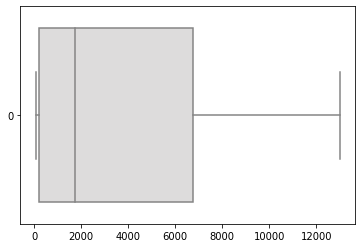

In [84]:
#Can do entire dataframe with orient='h'
sns.boxplot(data=train_df['Health Indicator'].value_counts(),palette='coolwarm',orient='h')

Instead of imputing data with most_frequent value, I will be creating a new tag for missing data (this can be refered to as unknown categorgy). I believe, imputing with most_frequent value can create unnecessary bias in our dataset

In [85]:
train_df['Holding_Policy_Duration'].value_counts()

1.0     4499
14+     4335
2.0     4260
3.0     3586
4.0     2771
5.0     2362
6.0     1894
7.0     1645
8.0     1316
9.0     1114
10.0     813
11.0     546
12.0     513
13.0     511
14.0     466
Name: Holding_Policy_Duration, dtype: int64

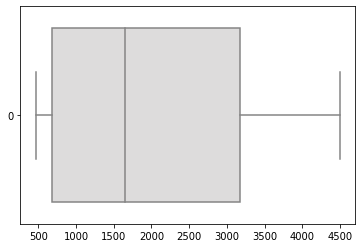

In [86]:
#Can do entire dataframe with orient='h'
sns.boxplot(data=train_df['Holding_Policy_Duration'].value_counts(), palette='coolwarm', orient='h')

In [87]:
train_df['Holding_Policy_Type'].value_counts()

3.0    13279
1.0     8173
2.0     5005
4.0     4174
Name: Holding_Policy_Type, dtype: int64

Instaed of imputing data with most_frequent value, I will be creating a new tag for missing data, namely, X0 (this can be refered to as unknown categorgy). I believe, imputing with most_frequent value can create unnecessary bias in our dataset

In [88]:
train_df['Health Indicator'].replace(np.nan, 'X0', inplace=True)
train_df['Holding_Policy_Duration'].replace(np.nan, '0.0', inplace=True)
train_df['Holding_Policy_Duration'].replace('14+', '15.0', inplace=True)
train_df['Holding_Policy_Type'].replace(np.nan, '0.0', inplace=True)

test_df['Health Indicator'].replace(np.nan, 'X0', inplace=True)
test_df['Holding_Policy_Duration'].replace(np.nan, '0.0', inplace=True)
test_df['Holding_Policy_Duration'].replace('14+', '15.0', inplace=True)
test_df['Holding_Policy_Type'].replace(np.nan, '0.0', inplace=True)

In [89]:
train_df.isna().sum()

ID                         0
City_Code                  0
Region_Code                0
Accomodation_Type          0
Reco_Insurance_Type        0
Upper_Age                  0
Lower_Age                  0
Is_Spouse                  0
Health Indicator           0
Holding_Policy_Duration    0
Holding_Policy_Type        0
Reco_Policy_Cat            0
Reco_Policy_Premium        0
Response                   0
dtype: int64

In [90]:
test_df.isna().sum()

ID                         0
City_Code                  0
Region_Code                0
Accomodation_Type          0
Reco_Insurance_Type        0
Upper_Age                  0
Lower_Age                  0
Is_Spouse                  0
Health Indicator           0
Holding_Policy_Duration    0
Holding_Policy_Type        0
Reco_Policy_Cat            0
Reco_Policy_Premium        0
dtype: int64

In [91]:
#  lets drop ID columns
train_df.drop(labels=['ID'], axis=1, inplace=True)
test_df.drop(labels=['ID'], axis=1, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000012CAC6E4488>,
      dtype=object)

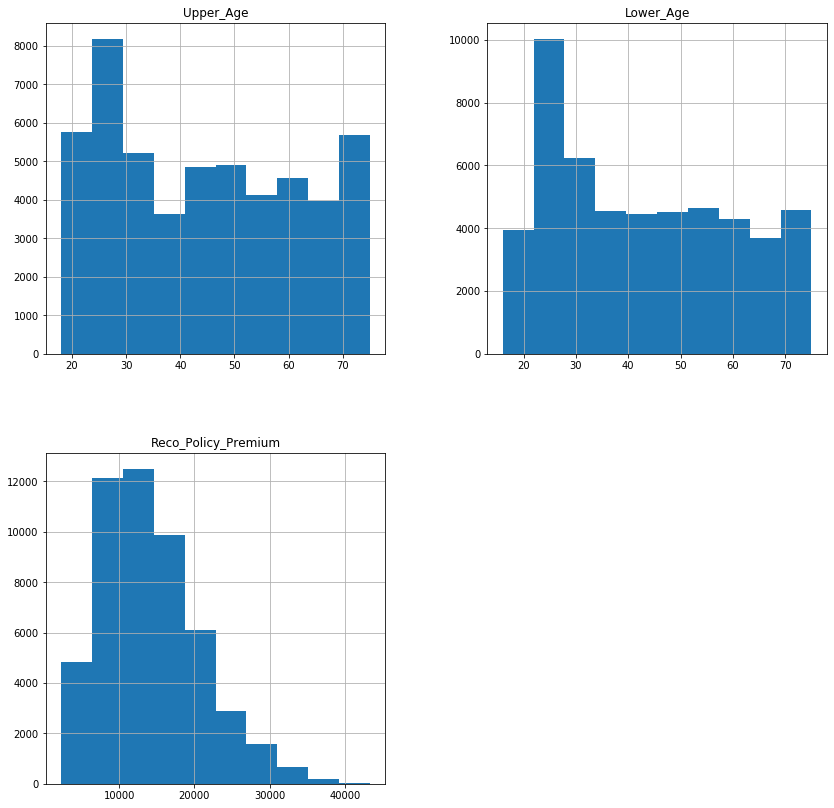

In [92]:
train_df[['Upper_Age', 'Lower_Age', 'Reco_Policy_Premium']].hist(figsize=(14,14))

In [93]:
# converting all categorical features as string
categorical_features_list = ['City_Code', 'Region_Code', 'Upper_Age', 'Lower_Age', 'Accomodation_Type','Reco_Insurance_Type', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Type', 'Reco_Policy_Cat']
for col in categorical_features_list:
    train_df[col] = train_df[col].astype('str')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City_Code                50882 non-null  object 
 1   Region_Code              50882 non-null  object 
 2   Accomodation_Type        50882 non-null  object 
 3   Reco_Insurance_Type      50882 non-null  object 
 4   Upper_Age                50882 non-null  object 
 5   Lower_Age                50882 non-null  object 
 6   Is_Spouse                50882 non-null  object 
 7   Health Indicator         50882 non-null  object 
 8   Holding_Policy_Duration  50882 non-null  object 
 9   Holding_Policy_Type      50882 non-null  object 
 10  Reco_Policy_Cat          50882 non-null  object 
 11  Reco_Policy_Premium      50882 non-null  float64
 12  Response                 50882 non-null  int64  
dtypes: float64(1), int64(1), object(11)
memory usage: 5.0+ MB


In [94]:
# converting all categorical features as string
categorical_features_list = ['City_Code', 'Region_Code', 'Upper_Age', 'Lower_Age', 'Accomodation_Type','Reco_Insurance_Type', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Type', 'Reco_Policy_Cat']
for col in categorical_features_list:
    test_df[col] = train_df[col].astype('str')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21805 entries, 0 to 21804
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City_Code                21805 non-null  object 
 1   Region_Code              21805 non-null  object 
 2   Accomodation_Type        21805 non-null  object 
 3   Reco_Insurance_Type      21805 non-null  object 
 4   Upper_Age                21805 non-null  object 
 5   Lower_Age                21805 non-null  object 
 6   Is_Spouse                21805 non-null  object 
 7   Health Indicator         21805 non-null  object 
 8   Holding_Policy_Duration  21805 non-null  object 
 9   Holding_Policy_Type      21805 non-null  object 
 10  Reco_Policy_Cat          21805 non-null  object 
 11  Reco_Policy_Premium      21805 non-null  float64
dtypes: float64(1), object(11)
memory usage: 2.0+ MB


#### Resampling training Dataset usinf SMOTENC

In [95]:
smote = SMOTENC(categorical_features=[0,1,2,3,4,5,6,7,8,9,10], random_state=42)
# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(train_df.iloc[:,:-1], train_df['Response'])
train_df_resampled = x_smote
train_df_resampled['Response'] = y_smote
train_df_resampled

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,C3,3213,Rented,Individual,36,36,No,X1,15.0,3.0,22,11628.000000,0
1,C5,1117,Owned,Joint,75,22,No,X2,0.0,0.0,22,30510.000000,0
2,C5,3732,Owned,Individual,32,32,No,X0,1.0,1.0,19,7450.000000,1
3,C24,4378,Owned,Joint,52,48,No,X1,15.0,3.0,19,17780.000000,0
4,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77341,C13,234,Owned,Individual,64,64,No,X0,9.0,3.0,19,18873.460293,1
77342,C2,419,Owned,Individual,54,54,No,X3,0.0,0.0,22,16155.658028,1
77343,C27,22,Owned,Joint,42,41,Yes,X2,1.0,3.0,17,20312.726832,1
77344,C1,2463,Rented,Individual,22,22,No,X3,0.0,0.0,20,10321.625652,1


In [96]:
train_df_resampled.drop_duplicates(keep='first', inplace=True)
train_df_resampled

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,C3,3213,Rented,Individual,36,36,No,X1,15.0,3.0,22,11628.000000,0
1,C5,1117,Owned,Joint,75,22,No,X2,0.0,0.0,22,30510.000000,0
2,C5,3732,Owned,Individual,32,32,No,X0,1.0,1.0,19,7450.000000,1
3,C24,4378,Owned,Joint,52,48,No,X1,15.0,3.0,19,17780.000000,0
4,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77341,C13,234,Owned,Individual,64,64,No,X0,9.0,3.0,19,18873.460293,1
77342,C2,419,Owned,Individual,54,54,No,X3,0.0,0.0,22,16155.658028,1
77343,C27,22,Owned,Joint,42,41,Yes,X2,1.0,3.0,17,20312.726832,1
77344,C1,2463,Rented,Individual,22,22,No,X3,0.0,0.0,20,10321.625652,1


### One Hot Encoding

In [97]:
set(train_df['Region_Code'].unique()).intersection(set(test_df['Region_Code'].unique()))

{'1569',
 '4489',
 '1786',
 '82',
 '675',
 '3151',
 '1513',
 '1815',
 '69',
 '1517',
 '1149',
 '3879',
 '378',
 '1279',
 '1782',
 '646',
 '2638',
 '2853',
 '795',
 '1501',
 '2908',
 '3429',
 '5000',
 '4143',
 '309',
 '4087',
 '3507',
 '36',
 '1353',
 '4083',
 '3798',
 '3678',
 '5429',
 '1487',
 '1581',
 '3763',
 '25',
 '3047',
 '5648',
 '1980',
 '3921',
 '1906',
 '1286',
 '858',
 '3259',
 '2659',
 '2594',
 '2840',
 '4318',
 '6004',
 '2643',
 '2884',
 '1082',
 '1374',
 '5610',
 '2386',
 '3273',
 '606',
 '4223',
 '5132',
 '3236',
 '1631',
 '4457',
 '4092',
 '2531',
 '3759',
 '4195',
 '867',
 '3909',
 '3610',
 '368',
 '3099',
 '5870',
 '337',
 '1347',
 '1747',
 '3588',
 '4188',
 '4803',
 '3104',
 '4028',
 '3200',
 '4581',
 '340',
 '4791',
 '5055',
 '3762',
 '4302',
 '2559',
 '2253',
 '3767',
 '488',
 '4663',
 '3720',
 '3966',
 '2794',
 '3930',
 '29',
 '1016',
 '3731',
 '5027',
 '664',
 '419',
 '5574',
 '4784',
 '446',
 '3977',
 '2161',
 '2084',
 '450',
 '2273',
 '3053',
 '237',
 '3474',
 

As per my analysis, I found that there are some more Region Code avalaible in test data set

So, lets Combining both train and test dataset to apply one hot encoding, this will ensure that any unique values in both the dataset will be treated accordingly and wont produce feature error during prediction

In [98]:
combined = pd.concat([train_df_resampled,test_df],axis=0)
combined

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,C3,3213,Rented,Individual,36,36,No,X1,15.0,3.0,22,11628.0,0.0
1,C5,1117,Owned,Joint,75,22,No,X2,0.0,0.0,22,30510.0,0.0
2,C5,3732,Owned,Individual,32,32,No,X0,1.0,1.0,19,7450.0,1.0
3,C24,4378,Owned,Joint,52,48,No,X1,15.0,3.0,19,17780.0,0.0
4,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21800,C1,889,Owned,Individual,72,72,No,X0,4.0,0.0,22,15884.0,NaN
21801,C8,4796,Owned,Individual,56,56,No,X1,6.0,0.0,21,21390.0,NaN
21802,C4,751,Rented,Individual,75,75,No,X1,0.0,3.0,17,17836.0,NaN
21803,C16,4139,Owned,Individual,45,45,No,X0,3.0,1.0,19,11568.0,NaN


In [99]:
categorical_features = combined[categorical_features_list].astype('str')
categorical_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99147 entries, 0 to 21804
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   City_Code            99147 non-null  object
 1   Region_Code          99147 non-null  object
 2   Upper_Age            99147 non-null  object
 3   Lower_Age            99147 non-null  object
 4   Accomodation_Type    99147 non-null  object
 5   Reco_Insurance_Type  99147 non-null  object
 6   Is_Spouse            99147 non-null  object
 7   Health Indicator     99147 non-null  object
 8   Holding_Policy_Type  99147 non-null  object
 9   Reco_Policy_Cat      99147 non-null  object
dtypes: object(10)
memory usage: 8.3+ MB


In [100]:
categorical_features_encoded = pd.get_dummies(categorical_features, drop_first=True)
categorical_features_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99147 entries, 0 to 21804
Columns: 5503 entries, City_Code_C10 to Reco_Policy_Cat_9
dtypes: uint8(5503)
memory usage: 521.1 MB


In [101]:
train_df_encoded = combined.drop(labels=categorical_features_list, axis=1)
train_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99147 entries, 0 to 21804
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Holding_Policy_Duration  99147 non-null  object 
 1   Reco_Policy_Premium      99147 non-null  float64
 2   Response                 77342 non-null  float64
dtypes: float64(2), object(1)
memory usage: 3.0+ MB


In [102]:
for col in categorical_features_encoded.columns:
    train_df_encoded[col] = categorical_features_encoded[col]
train_df_encoded.shape

(99147, 5506)

#### Normalizing numerical features

In [103]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical = ['Reco_Policy_Premium']
train_df_encoded[numerical] = scaler.fit_transform(train_df_encoded[numerical])
train_df_encoded[numerical]

,Reco_Policy_Premium
0,0.227657
1,0.681290
2,0.127282
3,0.375456
4,0.198251
...,...
21800,0.329906
21801,0.462185
21802,0.376802
21803,0.226216


In [104]:
# separating training and test data set
train_x = train_df_encoded[train_df_encoded['Response'].isin((0.0,1.0))]
train_x

,Holding_Policy_Duration,Reco_Policy_Premium,Response,City_Code_C10,City_Code_C11,City_Code_C12,City_Code_C13,City_Code_C14,City_Code_C15,City_Code_C16,...,Reco_Policy_Cat_20,Reco_Policy_Cat_21,Reco_Policy_Cat_22,Reco_Policy_Cat_3,Reco_Policy_Cat_4,Reco_Policy_Cat_5,Reco_Policy_Cat_6,Reco_Policy_Cat_7,Reco_Policy_Cat_8,Reco_Policy_Cat_9
0,15.0,0.227657,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0.0,0.681290,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1.0,0.127282,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15.0,0.375456,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,0.198251,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77341,9.0,0.401726,1.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77342,0.0,0.336432,1.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
77343,1.0,0.436304,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77344,0.0,0.196272,1.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [105]:
train_y = train_df_encoded[~ train_df_encoded['Response'].isin((0.0,1.0))]
train_y

,Holding_Policy_Duration,Reco_Policy_Premium,Response,City_Code_C10,City_Code_C11,City_Code_C12,City_Code_C13,City_Code_C14,City_Code_C15,City_Code_C16,...,Reco_Policy_Cat_20,Reco_Policy_Cat_21,Reco_Policy_Cat_22,Reco_Policy_Cat_3,Reco_Policy_Cat_4,Reco_Policy_Cat_5,Reco_Policy_Cat_6,Reco_Policy_Cat_7,Reco_Policy_Cat_8,Reco_Policy_Cat_9
0,6.0,0.235009,NaN,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,3.0,0.722007,NaN,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,2.0,0.170286,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,0.166587,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.489669,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21800,4.0,0.329906,NaN,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
21801,6.0,0.462185,NaN,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
21802,0.0,0.376802,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21803,3.0,0.226216,NaN,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
response = train_x['Response']
training = train_x.drop(labels=['Response'], axis=1)
training

In [110]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca_fit = pca.fit(training)

In [111]:

def scree_plot(pca): ##code from helper_functions.py in PCA lesson
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    RETURN: None
    '''
    num_components= len(pca.explained_variance_ratio_)
    idx = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(idx, vals)
    ax.plot(idx, cumvals)
    for i in range(num_components):
        if(i%20 == 0 or i<6):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (idx[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=8)
 
    ax.xaxis.set_tick_params(width=0, gridOn=True)
    ax.yaxis.set_tick_params(width=2, length=12, gridOn=True)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

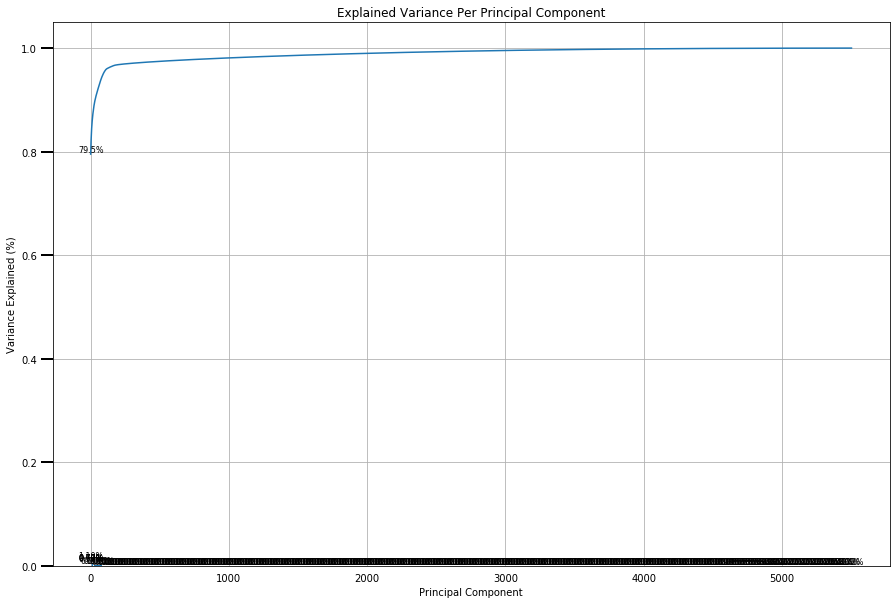

In [112]:
scree_plot(pca_fit)

In [115]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=225, random_state=42)
pca.fit(training)
pca_data = pca.transform(training)
pca_data.shape

(77342, 225)

In [123]:
# Model training and validation

def baseline_models(data=[], verbose=False):
    #List of models to be used
    models=[DecisionTreeClassifier(),LogisticRegression(),
            RandomForestClassifier(),GradientBoostingClassifier()]
    #Create training and testing data sets depending on wheather or not they have been generated previously.
    if len(data)== 2:
        X_train, X_test, y_train, y_test = train_test_split(data[0],data[1],random_state=123)
    else:
        X_train, X_test, y_train, y_test = data[0],data[1],data[2],data[3]
    #Instantiate lists to store each of the models results
    accuracy = []
    f1 = []
    auc = []
    recall = []
    precision = []
    #Run thorugh each of the models to get their performance metrics
    for model in models:
        clf = model
        clf.fit(X_train, y_train)
        test_preds = clf.predict(X_test)
        f1.append(f1_score(y_test, test_preds))
        accuracy.append(accuracy_score(y_test, test_preds))
        auc.append(roc_auc_score(y_test, test_preds))
        recall.append(recall_score(y_test, test_preds))
        precision.append(precision_score(y_test, test_preds))
        #Print the model and its report
        if verbose:
            print('Classification Model: ',model,'\n')
            print(classification_report(y_test, test_preds),'\n')
    #store results in dataframe
    results = pd.DataFrame([f1,auc, accuracy, precision,recall],
                      index= ['f1','roc_auc','accuracy','precision','recall',],
                           columns=['DecisionTree','LogisticRegression','RandomForest','Gradient Boosting'])
    #Change orientation of the dataframe
    return results.transpose()

In [124]:
response = train_x['Response']
training = train_x.drop(labels=['Response'], axis=1)
training

,Holding_Policy_Duration,Reco_Policy_Premium,City_Code_C10,City_Code_C11,City_Code_C12,City_Code_C13,City_Code_C14,City_Code_C15,City_Code_C16,City_Code_C17,...,Reco_Policy_Cat_20,Reco_Policy_Cat_21,Reco_Policy_Cat_22,Reco_Policy_Cat_3,Reco_Policy_Cat_4,Reco_Policy_Cat_5,Reco_Policy_Cat_6,Reco_Policy_Cat_7,Reco_Policy_Cat_8,Reco_Policy_Cat_9
0,15.0,0.227657,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0.0,0.681290,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1.0,0.127282,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15.0,0.375456,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,0.198251,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77341,9.0,0.401726,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77342,0.0,0.336432,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
77343,1.0,0.436304,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
77344,0.0,0.196272,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
result = baseline_models(data=[training, response], verbose=True)

In [ ]:
result

#### didn't use pca data, since performace of model was getting affected

In [138]:
# applying RandomForestClassifier with tuned params
X_train, X_test, y_train, y_test = train_test_split(training,response, test_size=0.2 ,random_state=123)
clf = RandomForestClassifier(n_estimators=600, random_state=42, criterion='entropy')
clf.fit(X_train,y_train)

In [127]:
test_preds = clf.predict(X_test)
print(f1_score(y_test, test_preds))
print(accuracy_score(y_test, test_preds))
print(roc_auc_score(y_test, test_preds))
print(recall_score(y_test, test_preds))
print(precision_score(y_test, test_preds))

0.8231511254019291
0.8186695972590342
0.818503978301638
0.8361726655565518
0.8105289297243605


In [143]:
# checked with cross validation, still getting 80 %
from sklearn.model_selection import cross_val_score
cross_val_scores = cross_val_score(RandomForestClassifier(n_estimators=600, random_state=42, criterion='entropy'),training,response , scoring='roc_auc', cv=5)

In [144]:
cross_val_scores

array([0.81259316, 0.86929208, 0.95629785, 0.95675085, 0.95563963])

In [145]:
np.mean(cross_val_scores)

0.9101147140208858

#### Predicting Test Data

In [133]:
train_y.drop(labels=['Response'], axis=1, inplace=True)

C:\Users\hp\anaconda3\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [134]:
train_y.isna().sum()

Holding_Policy_Duration    0
Reco_Policy_Premium        0
City_Code_C10              0
City_Code_C11              0
City_Code_C12              0
                          ..
Reco_Policy_Cat_5          0
Reco_Policy_Cat_6          0
Reco_Policy_Cat_7          0
Reco_Policy_Cat_8          0
Reco_Policy_Cat_9          0
Length: 5505, dtype: int64

In [135]:
test_pred1 = clf.predict_proba(train_y)
test_pred1

array([[0.50666667, 0.49333333],
       [0.795     , 0.205     ],
       [0.21666667, 0.78333333],
       ...,
       [0.76      , 0.24      ],
       [0.84166667, 0.15833333],
       [0.555     , 0.445     ]])

In [136]:
test_df = pd.read_csv("test_YCcRUnU.csv")
test_df['Response'] = pd.Series(pd.DataFrame(test_pred1)[1])
test_df

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,50883,C1,156,Owned,Individual,30,30,No,NaN,6.0,3.0,5,11934.0,0.493333
1,50884,C4,7,Owned,Joint,69,68,Yes,X1,3.0,3.0,18,32204.8,0.205000
2,50885,C1,564,Rented,Individual,28,28,No,X3,2.0,4.0,17,9240.0,0.783333
3,50886,C3,1177,Rented,Individual,23,23,No,X3,3.0,3.0,18,9086.0,0.251667
4,50887,C1,951,Owned,Individual,75,75,No,X3,NaN,NaN,5,22534.0,0.295000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21800,72683,C3,1044,Owned,Individual,45,45,No,X1,4.0,1.0,18,15884.0,0.276667
21801,72684,C4,266,Owned,Individual,59,59,No,X5,6.0,3.0,18,21390.0,0.230000
21802,72685,C12,2470,Owned,Individual,74,74,No,X3,NaN,NaN,1,17836.0,0.240000
21803,72686,C10,1676,Rented,Individual,25,25,No,X4,3.0,1.0,19,11568.0,0.158333


In [137]:
test_df[['ID', 'Response']].to_csv('sample_submission.csv', index=False)